In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopy.distance
import folium
import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr
sns.set( rc={'figure.figsize': (15, 8)})

In [4]:
stations_info = pd.read_excel('data/Estaciones.xlsx', sheet_name = 'INFO')
stations_maxima = pd.read_excel('data/Estaciones.xlsx', sheet_name = 'Maximos', index_col = 0, skiprows = 1)
stations_annual = pd.read_excel('data/Estaciones.xlsx', sheet_name = 'Anuales', index_col = 0, skiprows = 1)
stations_np95 = pd.read_excel('data/Estaciones.xlsx', sheet_name = 'Np95', index_col = 0, skiprows = 1)

In [5]:
reanalysis_info = pd.read_excel('data/datos NCEP NCAR.xlsx', sheet_name = 'INFO')
reanalysis_info['LATITUD (°S)'] = reanalysis_info['LATITUD (°S)'].astype(np.float32)
reanalysis_info['LONGITUD (°W)'] = reanalysis_info['LONGITUD (°W)'].astype(np.float32)

reanalysis_total = pd.read_excel('data/datos NCEP NCAR.xlsx', sheet_name = 'Total', index_col = 0)
reanalysis_maxima = pd.read_excel('data/datos NCEP NCAR.xlsx', sheet_name = 'Maximo', index_col = 0)#
reanalysis_np95 = pd.read_excel('data/datos NCEP NCAR.xlsx', sheet_name = 'Np95', index_col = 0)

In [6]:
var_ndefm = pd.read_excel('data/variables e indices NDEFM.xlsx', index_col = 0, usecols = 'A:G')

In [7]:
reanalysis_info.set_index('INDICATIVO', drop=True, inplace=True)

With the module *folium*, we plot the stations and the gridded points from the model NCEP-NCAR.

In [8]:
noa_map = folium.Map(location=[-28, -65], zoom_start=5, width=600, height=500,  tiles='Stamen Terrain')

In [9]:
for idx, (station, _prov, _org, coord, *_) in stations_info.iterrows():
    lat, lon = coord.split(',')
    marker = folium.Marker(location=[-float(lat), -float(lon)], tooltip=station, icon=folium.Icon(color='red'))
    marker.add_to(noa_map)

In [10]:
for idx, (lat, lon) in reanalysis_info.iterrows():
    marker = folium.CircleMarker(location=[-float(lat), -float(lon)], radius=5, tooltip=idx, fill = True, icon=folium.Icon(color='green'), fillOpacity = 0.8)
    marker.add_to(noa_map)

In [11]:
noa_map

Then we find the nearest station for each grid point and its distance

In [12]:
def nearest(v,stations):
    nearest = []
    for index, row in v.iterrows():
        coords_1 = row[['LATITUD (°S)', 'LONGITUD (°W)']].values
        dist = []
        for station in stations.iterrows():
            coords_2 = (station[1][0],station[1][1])
            dist.append(geopy.distance.vincenty(coords_1, coords_2).km)
        nearest.append([stations.index[np.where(dist == np.amin(dist))[0][0]],np.amin(dist)])
    return nearest                

In [13]:
station = []
for _, row in stations_info.iterrows():
    new_row = [row['Estacion']]
    new_row.extend(row['LAT (S), LONG (W)(º)'].split(','))
    station.append(new_row)
station = pd.DataFrame(station, columns=['Station', 'lat', 'long'])
station.set_index('Station', drop=True, inplace=True)
station['lat']  = station['lat'].astype(np.float32)
station['long']  = station['long'].astype(np.float32)

In [14]:
nearest_station = [i[0] for i in  nearest(reanalysis_info, station)]
nearest_distance = [i[1] for i in  nearest(reanalysis_info, station)]
reanalysis_info['nearest_station'] = nearest_station
reanalysis_info['distance'] = nearest_distance

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [15]:
reanalysis_info

,LATITUD (°S),LONGITUD (°W),nearest_station,distance
INDICATIVO,,,,
V1,30.0,60.0,La Maria,466.860576
V2,30.0,62.5,La Maria,276.703628
V3,30.0,65.0,Valle Viejo,182.811067
V4,30.0,67.5,Valle Viejo,240.805582
V5,30.0,70.0,Valle Viejo,447.942995
V6,27.5,60.0,La Maria,420.929006
V7,27.5,62.5,La Maria,180.011760
V8,27.5,65.0,Padilla,64.928227
V9,27.5,67.5,Pie de Medano,139.254049


Then we group grid points with the same nearest station, and plot the time series for each variable

In [16]:
df_max = {}
estaciones_unique = reanalysis_info['nearest_station'].unique()
for i in estaciones_unique:
    df_max[i] = stations_maxima[i]
    for rows in reanalysis_info.iterrows():
        if (rows[1]['nearest_station'] == i):
            df_max[i] = pd.DataFrame(df_max[i]).join(pd.DataFrame(reanalysis_maxima[rows[0]]))
        

In [17]:
df_annual = {}
stations_unique = reanalysis_info['nearest_station'].unique()
for i in estaciones_unique:
    df_annual[i] = stations_annual[i]
    for rows in reanalysis_info.iterrows():
        if (rows[1]['nearest_station'] == i):
            df_annual[i] = pd.DataFrame(df_annual[i]).join(pd.DataFrame(reanalysis_total[rows[0]]))
        

In [18]:
df_np95 = {}
stations_unique = reanalysis_info['nearest_station'].unique()
for i in stations_unique:
    df_np95[i] = stations_np95[i]
    for rows in reanalysis_info.iterrows():
        if (rows[1]['nearest_station'] == i):
            df_np95[i] = pd.DataFrame(df_np95[i]).join(pd.DataFrame(reanalysis_np95[rows[0]]))
        

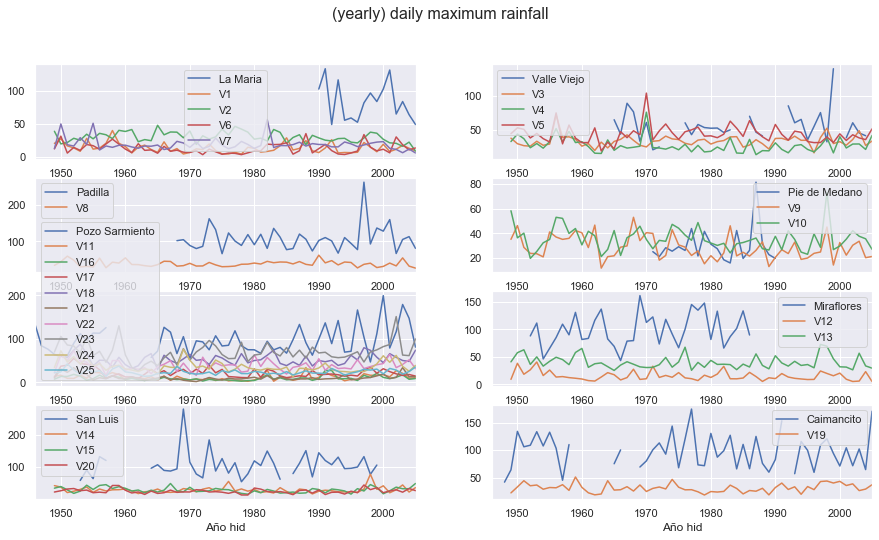

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.suptitle('(yearly) daily maximum rainfall', fontsize=16 )
df_max['La Maria'].plot(ax=axes[0,0])
df_max['Valle Viejo'].plot(ax=axes[0,1])
df_max['Padilla'].plot(ax=axes[1,0])
df_max['Pie de Medano'].plot(ax=axes[1,1])
df_max['Pozo Sarmiento'].plot(ax=axes[2,0])
df_max['Miraflores'].plot(ax=axes[2,1])
df_max['San Luis'].plot(ax=axes[3,0])
df_max['Caimancito'].plot(ax=axes[3,1])


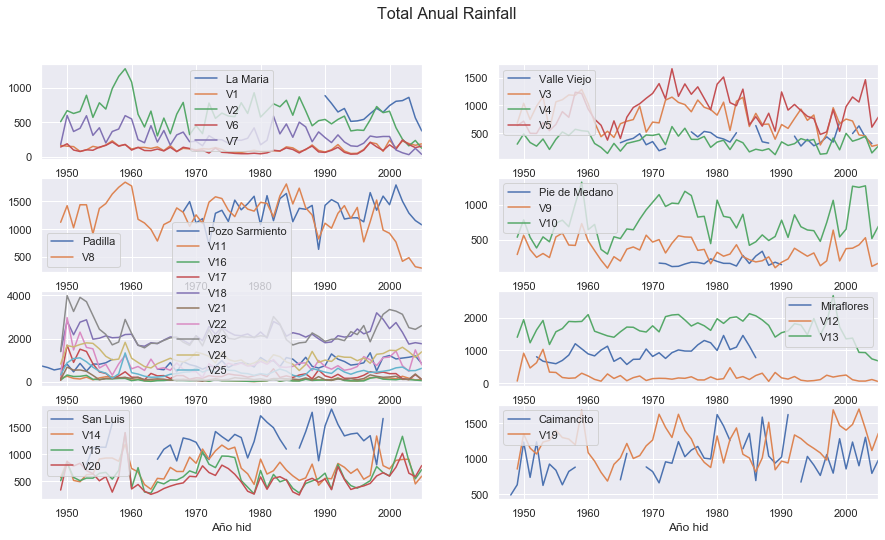

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.suptitle('Total Anual Rainfall', fontsize=16 )
df_annual['La Maria'].plot(ax=axes[0,0])
df_annual['Valle Viejo'].plot(ax=axes[0,1])
df_annual['Padilla'].plot(ax=axes[1,0])
df_annual['Pie de Medano'].plot(ax=axes[1,1])
df_annual['Pozo Sarmiento'].plot(ax=axes[2,0])
df_annual['Miraflores'].plot(ax=axes[2,1])
df_annual['San Luis'].plot(ax=axes[3,0])
df_annual['Caimancito'].plot(ax=axes[3,1])

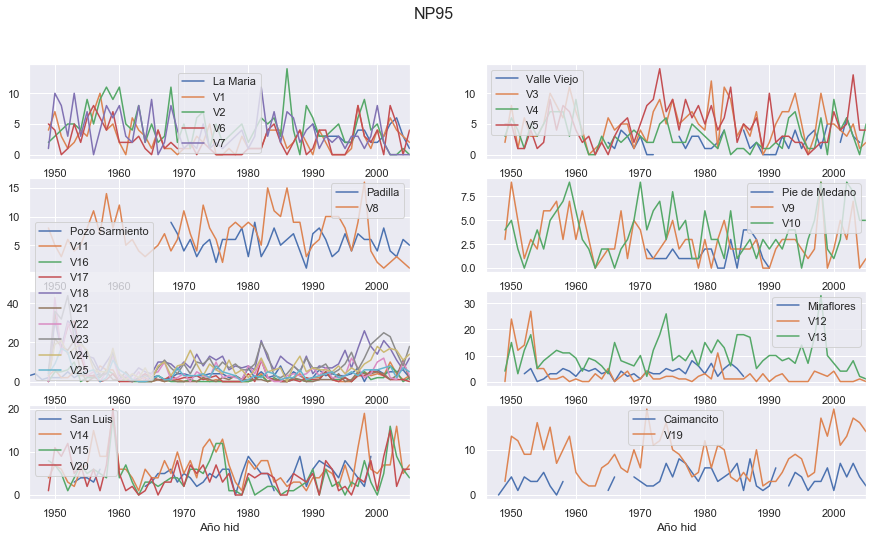

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.suptitle('NP95', fontsize=16 )
df_np95['La Maria'].plot(ax=axes[0,0])
df_np95['Valle Viejo'].plot(ax=axes[0,1])
df_np95['Padilla'].plot(ax=axes[1,0])
df_np95['Pie de Medano'].plot(ax=axes[1,1])
df_np95['Pozo Sarmiento'].plot(ax=axes[2,0])
df_np95['Miraflores'].plot(ax=axes[2,1])
df_np95['San Luis'].plot(ax=axes[3,0])
df_np95['Caimancito'].plot(ax=axes[3,1])

We compute the **pearson correlation coefficient** for each point and the nearest station

In [22]:
def pearson(df):
    p = {}
    for station in df.keys():
        for key in df[station].keys():
            x = df[station].dropna()[key]
            y = df[station].dropna()[station]
            if key!=station:
                p[key] = pearsonr(x,y)
            
    return p  

In [23]:
def add_distance(df):
    aux = []
    for key in df.keys():
        for v in df[key].keys():
            aux.append([reanalysis_info.loc[v].distance, df[key][v][0]])
        df_aux[key] = aux
    return df_aux

In [25]:
pearsons_np95 = pearson(df_np95)
pearsons_max = pearson(df_max)
pearsons_annual = pearson(df_annual)

We plot the pearson coefficient's histograms for each varible obtaining the distributions shown below

In [26]:
histogram_np95 = []
for key in pearsons_np95.keys():
    histogram_np95.append(pearsons_np95[key][0])

Text(0.5, 1.0, 'Histogram: pearson coefficients, Np95 data')

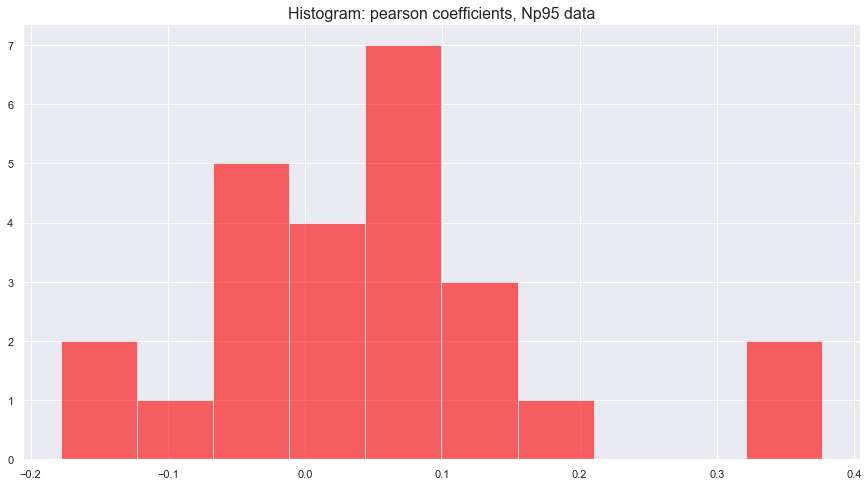

In [27]:
sns.distplot(histogram_np95, color="red", hist_kws={ "alpha": 0.6}, bins = 10,  kde = False).set_title('Histogram: pearson coefficients, Np95 data', fontsize=16, )

In [28]:
histogram_max = []
for key in pearsons_max.keys():
    histogram_max.append(pearsons_max[key][0])

Text(0.5, 1.0, 'Histogram: pearson coefficients, (yearly) maximun daily rainfall data')

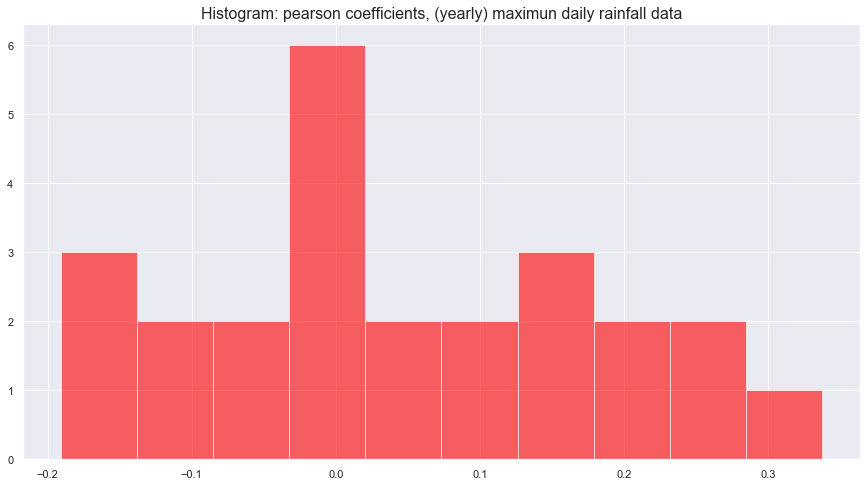

In [29]:
sns.distplot(histogram_max, color="red", hist_kws={ "alpha": 0.6}, bins = 10,  kde = False).set_title('Histogram: pearson coefficients, (yearly) maximun daily rainfall data', fontsize=16, )

In [33]:
histogram_annual = []
for key in pearsons_annual.keys():
    histogram_annual.append(pearsons_annual[key][0])

Text(0.5, 1.0, 'Histogram: pearson coefficient, annual rainfall data')

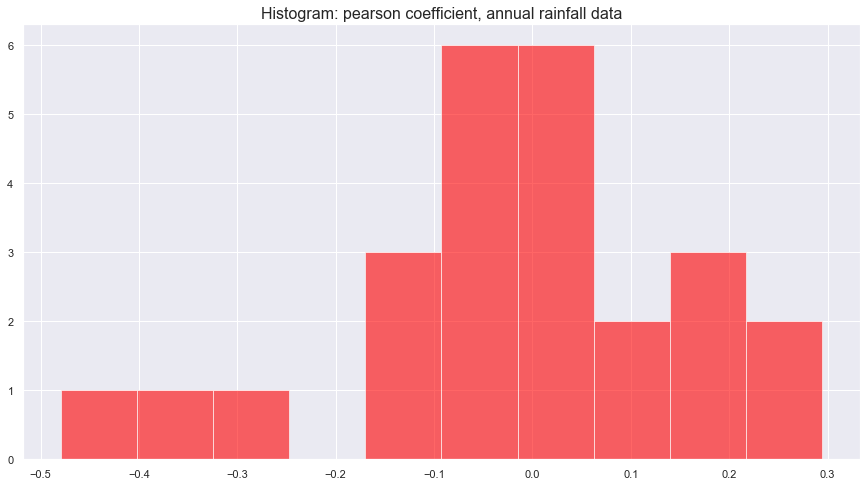

In [34]:
sns.distplot(histogram_annual, color="red", hist_kws={ "alpha": 0.6}, bins = 10,  kde = False).set_title('Histogram: pearson coefficient, annual rainfall data', fontsize=16 )

From the plots we notice for the variables *Precipitación Total Anual* and *Número de días con Precipitación mayor al percentil 95* that the pearson coefficients tend to be positive, but the ones for the variable *Precipitación Máxima Diaria Anual* don't have a trend.

In [35]:
distance_np95 = [reanalysis_info.loc[i][3] for i in pearsons_np95.keys()]
distance_max =  [reanalysis_info.loc[i][3] for i in pearsons_max.keys()]
distance_annual = [reanalysis_info.loc[i][3] for i in pearsons_annual.keys()]

We plot now the **pearson coefficient** vs **distance to the nearest station** for each variable

Text(0.5, 1.0, 'Pearson coefficient vs distance to nearest station, NP95 data')

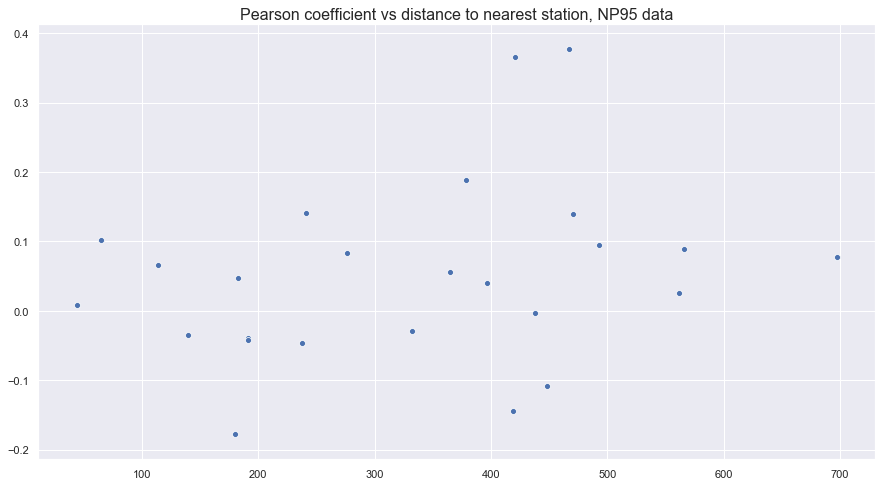

In [36]:
sns.scatterplot(x=distance_np95, y = histogram_np95).set_title('Pearson coefficient vs distance to nearest station, NP95 data', fontsize=16 )


Text(0.5, 1.0, 'Pearson coefficient vs distance to nearest station, (yearly) maximum daily rainfall data')

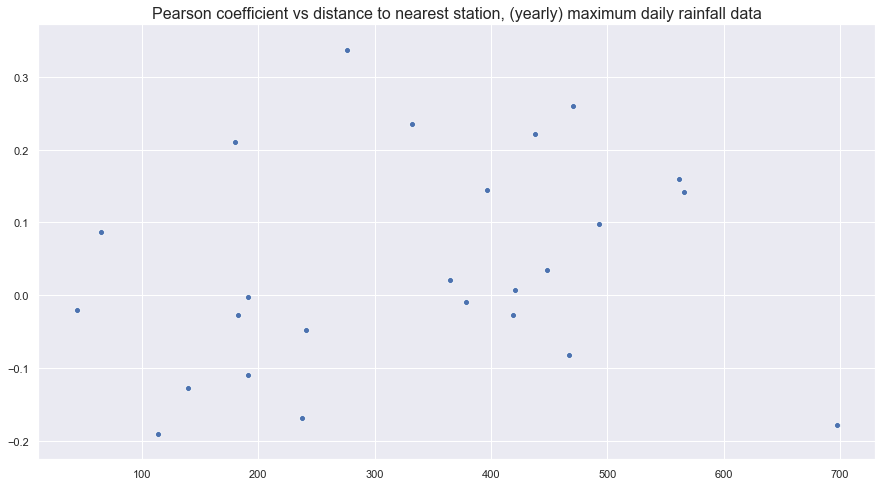

In [37]:
sns.scatterplot(x=distance_max, y = histogram_max ).set_title('Pearson coefficient vs distance to nearest station, (yearly) maximum daily rainfall data', fontsize=16 )

Text(0.5, 1.0, 'Pearson coefficient vs distance to nearest station, total annual rainfall data')

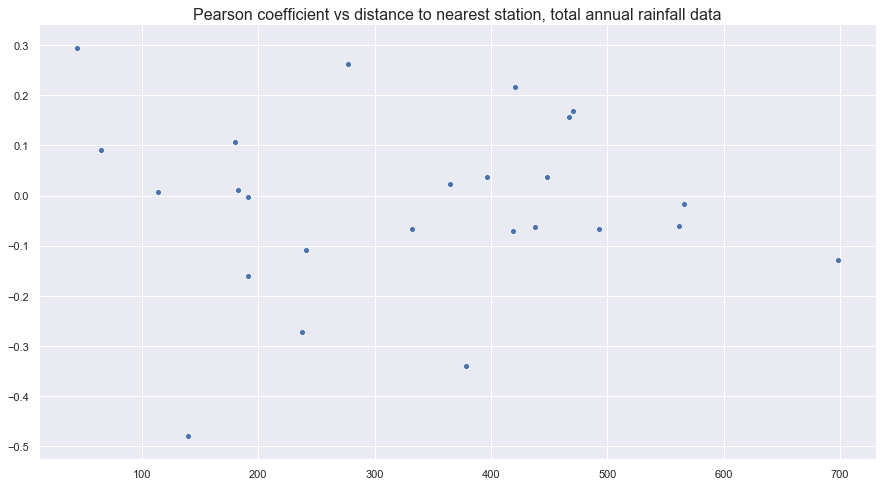

In [38]:
sns.scatterplot(x=distance_annual, y = histogram_annual).set_title('Pearson coefficient vs distance to nearest station, total annual rainfall data', fontsize=16 )

Now the **mean percentage error** is computed for each point, then it is plotted vs the distance to the nearest station 

In [39]:
def mean_error(df):
    mean_err = {}
    for i in df.keys():
        a = df[i].dropna()
        main_distance = a[a.columns[0]].sum()
       # mean_err[i] = {}
        for cols in a.columns[1:]:
            aux = ((a[cols] - a[a.columns[0]]).abs()/(a[a.columns[0]])).replace([np.inf, -np.inf], np.nan).dropna()
            mean_err[cols] = aux.sum()/len(aux.index)
    return mean_err

In [40]:
max_mean_error = mean_error(df_max)
annual_mean_error = mean_error(df_annual)
np95_mean_error = mean_error(df_np95)

In [41]:
histogram_max_mean_error = [max_mean_error[key] for key in max_mean_error.keys()]
histogram_annual_mean_error= [annual_mean_error[key] for key in annual_mean_error.keys()]
histogram_np95_mean_error = [np95_mean_error [key] for key in np95_mean_error.keys()]

Text(0.5, 1.0, 'Mean percentage error vs distance to nearest station, (yearly) maximum daily rainfall data')

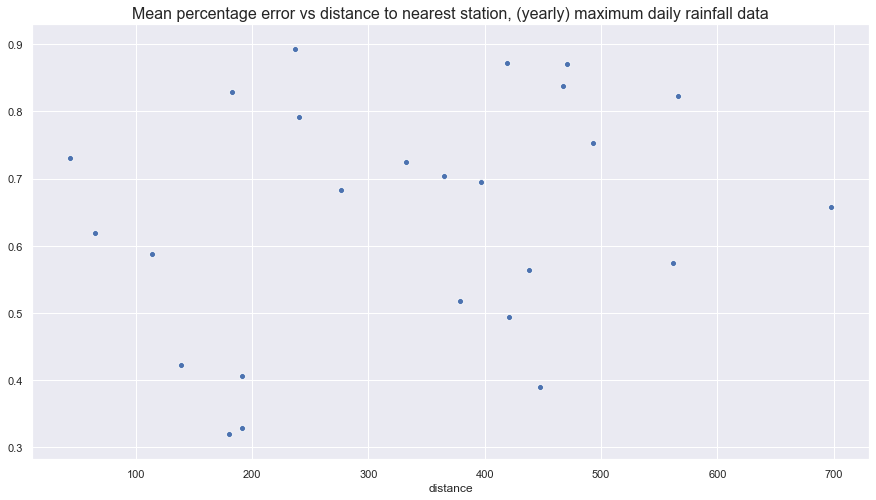

In [42]:
sns.scatterplot(x=reanalysis_info['distance'], y = histogram_max_mean_error ).set_title('Mean percentage error vs distance to nearest station, (yearly) maximum daily rainfall data', fontsize=16 )

Text(0.5, 1.0, 'Mean percentage error vs distance to nearest station, NP95 data')

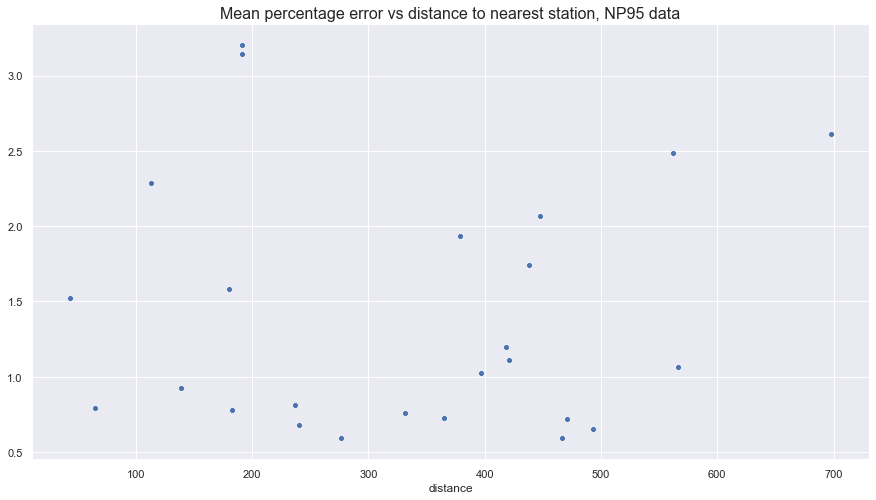

In [43]:
sns.scatterplot(x=reanalysis_info['distance'], y = histogram_np95_mean_error ).set_title('Mean percentage error vs distance to nearest station, NP95 data', fontsize=16 )

Text(0.5, 1.0, 'Mean percentage error vs distance to nearest station, annual rainfall data')

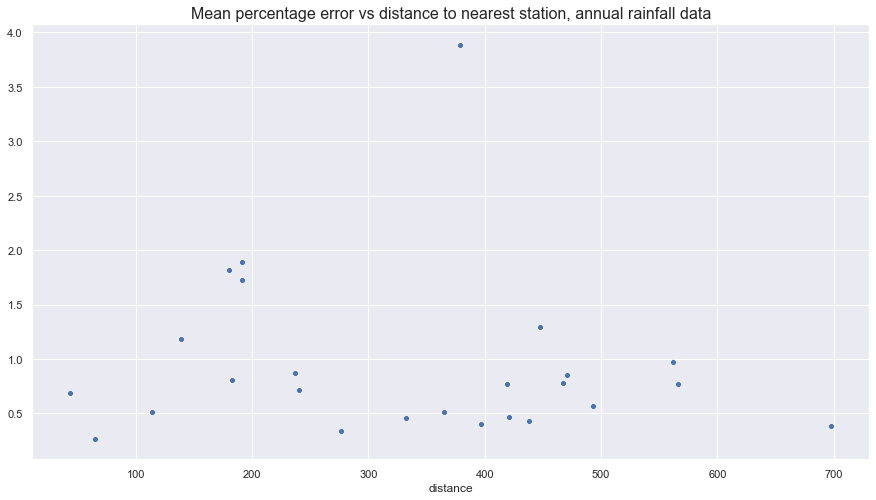

In [44]:
sns.scatterplot(x=reanalysis_info['distance'], y = histogram_annual_mean_error ).set_title('Mean percentage error vs distance to nearest station, annual rainfall data', fontsize=16 )

Neither the pearson coefficients nor the mean percentage errors have a trend with the distance to the nearest station

In [45]:
noa_map = folium.Map(location=[-28, -65], zoom_start=5, width=600, height=500,  tiles='Stamen Terrain')

In [46]:
for idx, (station, _prov, _org, coord, *_) in stations_info.iterrows():
    lat, lon = coord.split(',')
    marker = folium.Marker(location=[-float(lat), -float(lon)], tooltip=station, icon=folium.Icon(color='red'))
    marker.add_to(noa_map)

In [47]:
for idx, (lat, lon,_,_) in reanalysis_info.iterrows():
    marker = folium.CircleMarker(location=[-float(lat), -float(lon)], radius=5, tooltip=idx, popup = 'p_annual:'+str('{:1.2f}'.format(pearsons_annual[idx][0])) + ' p_max:'+str('{:1.2f}'.format(pearsons_max[idx][0])) + ' p_np95:'+str('{:1.2f}'.format(pearsons_np95[idx][0])),fill = True, icon=folium.Icon(color='green'), fillOpacity = 0.8)
    marker.add_to(noa_map)


In [48]:
noa_map

The pearson coefficient is compute, but now with *k* nearest stations, weighting each time series with a normalized inverse of its distance

In [49]:
def k_nearest(v, stations, k):
    nearest = {}
    for index, row in v.iterrows():
        coords_1 = row[['LATITUD (°S)', 'LONGITUD (°W)']].values
        dist = {}
        for station in stations.iterrows():
           # print(estation[1][3].split(","))
            coords_2 = station[1][3].split(",")
            dist[geopy.distance.vincenty(coords_1, coords_2).km] = station[1][0]
        lst = dist.keys()
        nearest[index] = [[dist[i],i] for i in sorted(lst)[:k]]

    return nearest                

In [50]:
def weighted_pearson(df_stations, df_v, nearest_stations):
    p = {}
    
    for v in df_v.keys():
        total_weight = 0
        v_weighted_series = pd.DataFrame([0]*len(df_v.index), columns = ['weighted series'], index =  df_v.index)
        for nearest_station in nearest_stations[v]:
            if nearest_station[0]!='Miraflores':
                v_weighted_series['weighted series']= v_weighted_series['weighted series'].add(df_stations[nearest_station[0]]*(1/nearest_station[1]))
                total_weight+= 1/nearest_station[1]
        v_weighted_series/=total_weight
        aux = {}
        v_weighted_series = v_weighted_series.join(df_v[v])
        v_weighted_series= v_weighted_series.dropna()
        if len(v_weighted_series[v].values)>=10:
            p[v] = pearsonr(v_weighted_series[v], v_weighted_series['weighted series'])
    return p
    

In [51]:
nearest_stations = k_nearest(reanalysis_info, stations_info, 3)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':


The weighted pearson coefficients are computed for those grid points where the calculation seems more reasonable. The grip points are plot in the next map, with the stations 

In [52]:
weighted_pearsons_annual = weighted_pearson(stations_annual, reanalysis_total, nearest_stations)

In [53]:
histogram_pearson_annual = []
histogram_annual_pearson_weighted = []
distances = []
keys = ['V2','V3','V7','V8', 'V12', 'V13', 'V17', 'V18']
for key in keys:
    histogram_pearson_annual.append(pearsons_annual[key][0])
    histogram_annual_pearson_weighted.append(weighted_pearsons_annual[key][0])
    distances.append(reanalysis_info.loc[key][3])

In [54]:
noa_map = folium.Map(location=[-27, -65], zoom_start=5, width=600, height=500,  tiles='Stamen Terrain')

In [55]:
for idx, (station, _prov, _org, coord, *_) in stations_info.iterrows():
    lat, lon = coord.split(',')
    marker = folium.Marker(location=[-float(lat), -float(lon)], tooltip=station, icon=folium.Icon(color='red'))
    marker.add_to(noa_map)

In [56]:
for idx, (lat, lon,_,_) in reanalysis_info.iterrows():
    if idx in keys:
        marker = folium.CircleMarker(location=[-float(lat), -float(lon)], radius=5, tooltip=idx, popup = 'p_annual:'+str('{:1.2f}'.format(pearsons_annual[idx][0])) + ' p_max:'+str('{:1.2f}'.format(pearsons_max[idx][0])) + ' p_np95:'+str('{:1.2f}'.format(pearsons_np95[idx][0])),fill = True, icon=folium.Icon(color='green'), fillOpacity = 0.8)
        marker.add_to(noa_map)
noa_map

The lollipop plots of the weighted pearson obtained with  k = 1 and k = 3 nearest neighbors are shown below 

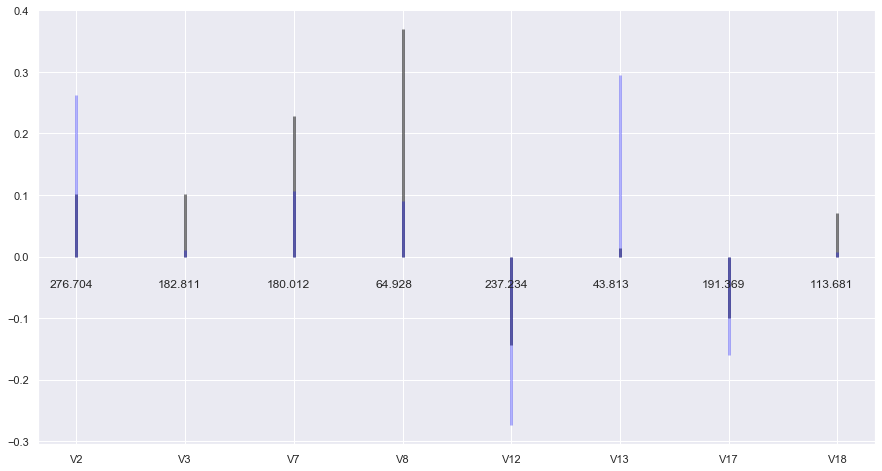

In [57]:
plt.vlines(ymin = 0, ymax = histogram_annual_pearson_weighted, x = keys, color='black' ,linewidth=3, alpha =0.5)
plt.vlines(ymin = 0, ymax = histogram_pearson_annual, x = keys, color='blue' ,linewidth=3, alpha =0.3)
x = [-0.25, 0.75, 1.75,2.75,3.75,4.75,5.75, 6.75, 7.75]
for i in range(len(distances)): 
    plt.text(x[i], y = -0.05,s= '{:.3f}'.format(distances[i]))

The pearson coefficients tend to be, in general, more positive, with a singular trend in **V13**. This anomally can be explained plotting the nearest station and the grid point in the map.

In [58]:
noa_map = folium.Map(location=[-25, -65], zoom_start=7, width=600, height=500,  tiles='Stamen Terrain')
for i in nearest_stations['V13']:
    lat, lon = stations_info[stations_info['Estacion'] == i[0]]['LAT (S), LONG (W)(º)'].values[0].split(",")
    marker = folium.Marker(location=[-float(lat), -float(lon)], tooltip = i[0], icon=folium.Icon(color='red'))
    marker.add_to(noa_map)

marker = folium.CircleMarker(location=[-float(reanalysis_info['LATITUD (°S)']['V13']), -float(reanalysis_info['LONGITUD (°W)']['V13'])], radius=5, tooltip='V13',fill = True, icon=folium.Icon(color='green'), fillOpacity = 0.8)
marker.add_to(noa_map)

noa_map

If 3 nearest neighbors are taking into account to compute the pearson coefficient of the grid point **V13**, the stations *San Luis* and *Caimancito*, which are in opposite directions, bring variability to the final time sries, decreasing the pearson coefficient. Also, the station *Miraflores* is near enough to compute the pearson's r and have a good value.

In [59]:
weighted_pearsons_max= weighted_pearson(stations_maxima, reanalysis_maxima, nearest_stations)
histogram_weighted_pearson_max= []
histogram_pearson_max = []
keys = ['V2','V3','V7','V8', 'V12', 'V13', 'V17', 'V18']
for key in keys:
    histogram_pearson_max.append(pearsons_max[key][0])
    histogram_weighted_pearson_max.append(weighted_pearsons_max[key][0])

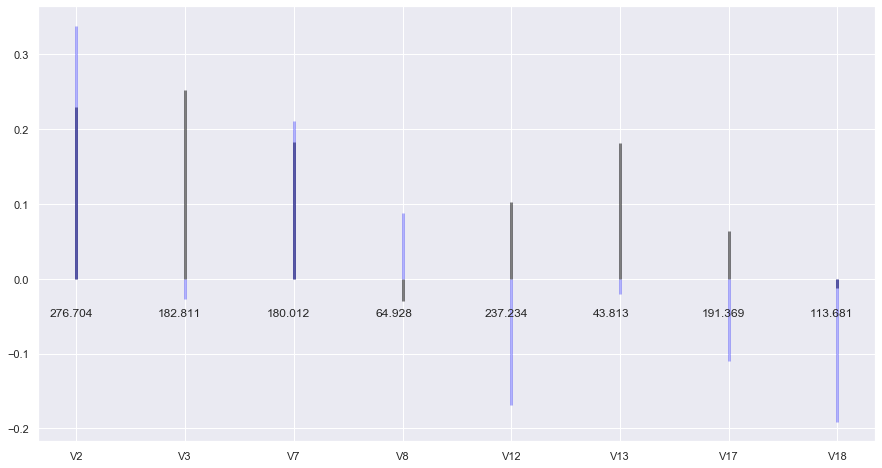

In [60]:
plt.vlines(ymin = 0, ymax = histogram_weighted_pearson_max, x = keys, color='black' ,linewidth=3, alpha =0.5)
plt.vlines(ymin = 0, ymax = histogram_pearson_max, x = keys, color='blue' ,linewidth=3, alpha =0.3)
x = [-0.25, 0.75, 1.75,2.75,3.75,4.75,5.75, 6.75, 7.75]
for i in range(len(distances)): 
    plt.text(x[i], y = -0.05,s= '{:.3f}'.format(distances[i]))

The same trend is found in the weighted pearsons of the annual data

In [61]:
weighted_pearsons_annual= weighted_pearson(stations_annual, reanalysis_total, nearest_stations)
histogram_weighted_pearson_annual= []
histogram_pearson_annual = []
keys = ['V2','V3','V7','V8', 'V12', 'V13', 'V17', 'V18']
for key in keys:
    histogram_pearson_annual.append(pearsons_annual[key][0])
    histogram_weighted_pearson_annual.append(weighted_pearsons_annual[key][0])

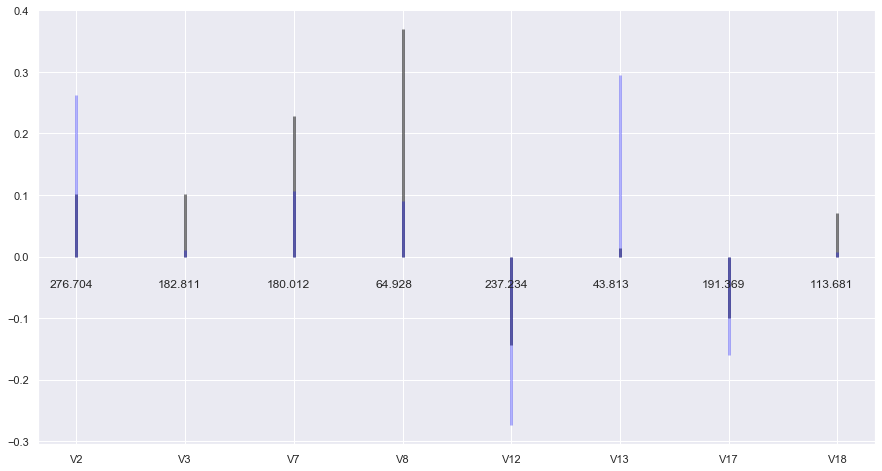

In [62]:
plt.vlines(ymin = 0, ymax = histogram_weighted_pearson_annual, x = keys, color='black' ,linewidth=3, alpha =0.5)
plt.vlines(ymin = 0, ymax = histogram_pearson_annual, x = keys, color='blue' ,linewidth=3, alpha =0.3)
x = [-0.25, 0.75, 1.75,2.75,3.75,4.75,5.75, 6.75, 7.75]
for i in range(len(distances)): 
    plt.text(x[i], y = -0.05,s= '{:.3f}'.format(distances[i]))

With the NP95 data, the pearson coefficients taking 3 nearest neighbors is more positive in 2 grid points with the lowest distance to the nearest station, but tend to be more negative for the others.

In [63]:
weighted_pearsons_np95 = weighted_pearson(stations_np95, reanalysis_np95, nearest_stations)
histogram_pearson_np95= []
histogram_weighted_pearson_np95 = []
keys = ['V2','V3','V7','V8', 'V12', 'V13', 'V17', 'V18']
for key in keys:
    histogram_pearson_np95.append(pearsons_np95[key][0])
    histogram_weighted_pearson_np95.append(weighted_pearsons_np95[key][0])

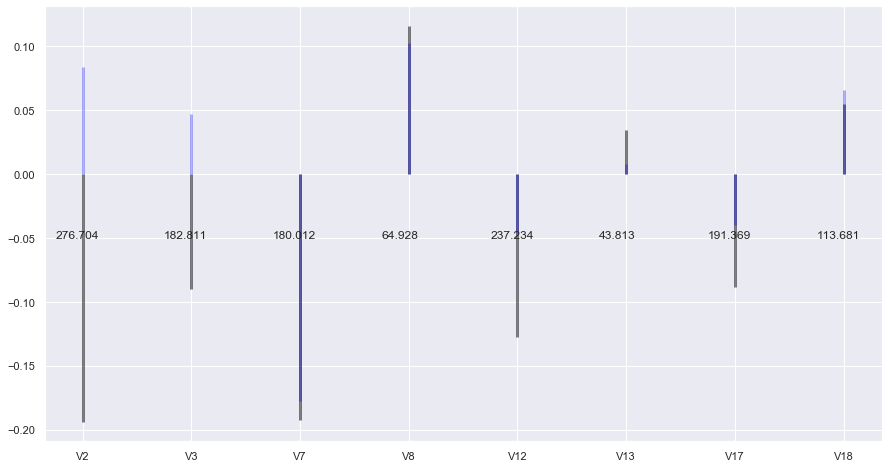

In [64]:
plt.vlines(ymin = 0, ymax = histogram_weighted_pearson_np95, x = keys, color='black' ,linewidth=3, alpha =0.5)
plt.vlines(ymin = 0, ymax = histogram_pearson_np95, x = keys, color='blue' ,linewidth=3, alpha =0.3)
x = [-0.25, 0.75, 1.75,2.75,3.75,4.75,5.75, 6.75, 7.75]
for i in range(len(distances)): 
    plt.text(x[i], y = -0.05,s= '{:.3f}'.format(distances[i]))